# Wrangling and Analyzing WeRateDogs Tweets

George J.J. Wu

## Gather

In [1]:
# libraries
import numpy as np
import pandas as pd
import requests
import tweepy
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings;

# set style to default
%matplotlib inline
sns.set()

# disable warnings
warnings.simplefilter('ignore')

In [2]:
# obtain image predictions from Udacity
r = requests.get("https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv")
with open("image_predictions.tsv", "wb") as f:
    f.write(r.content)

In [3]:
# load data
tweets_archive = pd.read_csv("twitter_archive_enhanced.csv")
breeds_predict = pd.read_csv("image_predictions.tsv", sep="\t")

In [ ]:
# obtain retweet count and like count from Twitter API
consumer_key = "****"
consumer_secret = "****"
access_token = "****"
access_secret = "****"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

json_file = open("tweet_json.txt", "w")
error_file = open("errorlog.txt", "w")

for id in tweets_archive["tweet_id"]:
    try:    
        tweet = api.get_status(str(id))
        print("accessing " + str(id))
        json.dump(tweet._json, json_file)
        json_file.write("\n")
    except tweepy.TweepError:
        print("Cannot access tweet for id: " + str(id))
        error_file.write(str(id) + "\n")
        
json_file.close()
error_file.close()

In [5]:
# create list of tweet information to convert to a DataFrame later
tweet_info = []

# obtain retweet count and favorite count from each tweet json
with open("tweet_json.txt") as json_file:
    for line in json_file:
        tweet_json = json.loads(line)
        tweet_id = tweet_json["id"]
        retweet_count = tweet_json["retweet_count"]
        fav_count = tweet_json["favorite_count"]
        # store the information in a dict
        entry = {"tweet_id": tweet_id,
                 "retweet_count": retweet_count,
                 "favorite_count": fav_count}
        # append dict to the list of tweet information
        tweet_info.append(entry)

In [6]:
# create DataFrame from list of tweet information
tweets_info = pd.DataFrame(tweet_info, 
                  columns = ["tweet_id", "retweet_count", "favorite_count"])

## Assess
The current investigation aims to analyze Twitter user WeRateDogs([@dog_rates](https://twitter.com/dog_rates))'s original ratings of dogs. Toward this goal, the current investigation looks for tweets that conform to the following schema:
* tweets should contain original ratings, and should not be retweets or replies.
* tweets should contain an image.
* tweets should be about dogs, and not about hens, turtles, goats, or bears.

### Visual assessment

In [7]:
tweets_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [8]:
breeds_predict.sample(15)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
386,673350198937153538,https://pbs.twimg.com/media/CVg4bo8WEAANEEE.jpg,1,West_Highland_white_terrier,0.119188,True,quill,0.104014,False,Maltese_dog,0.093944,True
1071,716439118184652801,https://pbs.twimg.com/media/CfFNk7cWAAA-hND.jpg,1,Siberian_husky,0.396495,True,malamute,0.317053,True,Eskimo_dog,0.273419,True
638,681281657291280384,https://pbs.twimg.com/media/CXRmDfWWMAADCdc.jpg,1,Saint_Bernard,0.998830,True,Pekinese,0.000391,True,Great_Pyrenees,0.000224,True
1487,782021823840026624,https://pbs.twimg.com/media/CdHwZd0VIAA4792.jpg,1,golden_retriever,0.383223,True,cocker_spaniel,0.165930,True,Chesapeake_Bay_retriever,0.118199,True
1018,710117014656950272,https://pbs.twimg.com/media/CdrXp9dWoAAcRfn.jpg,2,toy_poodle,0.802092,True,miniature_poodle,0.111647,True,cocker_spaniel,0.062866,True
162,668955713004314625,https://pbs.twimg.com/media/CUibq3uVAAAup_O.jpg,1,cocker_spaniel,0.367492,True,Lakeland_terrier,0.272621,True,soft-coated_wheaten_terrier,0.067006,True
389,673359818736984064,https://pbs.twimg.com/media/CVhBLohWEAAXtYl.jpg,1,English_setter,0.696568,True,Brittany_spaniel,0.104046,True,Ibizan_hound,0.034832,True
1239,746872823977771008,https://pbs.twimg.com/media/Cl1s1p7WMAA44Vk.jpg,1,Pembroke,0.540201,True,beagle,0.207835,True,Italian_greyhound,0.043565,True
1750,823939628516474880,https://pbs.twimg.com/media/C284uD8WgAEmMVn.jpg,1,schipperke,0.234076,True,curly-coated_retriever,0.193093,True,Labrador_retriever,0.095197,True
1936,860184849394610176,https://pbs.twimg.com/media/C-_9jWWUwAAnwkd.jpg,1,chimpanzee,0.267612,False,gorilla,0.104293,False,orangutan,0.059908,False


In [9]:
tweets_info.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8650,38986
1,892177421306343426,6355,33388
2,891815181378084864,4216,25159
3,891689557279858688,8765,42340
4,891327558926688256,9530,40495


### Programmatic Assessment

In [10]:
tweets_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [11]:
breeds_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [12]:
tweets_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345 entries, 0 to 2344
Data columns (total 3 columns):
tweet_id          2345 non-null int64
retweet_count     2345 non-null int64
favorite_count    2345 non-null int64
dtypes: int64(3)
memory usage: 55.0 KB


In [13]:
# check for duplicated tweets
tweets_archive[tweets_archive["tweet_id"].duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [14]:
# check for tweets that were replies and were not original ratings
tweets_archive[tweets_archive["in_reply_to_status_id"].notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
149,863079547188785154,6.671522e+17,4.196984e+09,2017-05-12 17:12:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Ladies and gentlemen... I found Pipsy. He may ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/863079547...,14,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
184,856526610513747968,8.558181e+17,4.196984e+09,2017-04-24 15:13:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...","THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/856526610...,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@xianmcguire @Jenna_Marbles Kardashians wouldn...,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None


In [15]:
# check for tweets that were retweets and were not original ratings
tweets_archive[tweets_archive["retweeted_status_id"].notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
74,878316110768087041,NaN,NaN,2017-06-23 18:17:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Terrance. He's being yelle...,6.690004e+17,4.196984e+09,2015-11-24 03:51:38 +0000,https://twitter.com/dog_rates/status/669000397...,11,10,Terrance,None,None,None,None
78,877611172832227328,NaN,NaN,2017-06-21 19:36:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @rachel2195: @dog_rates the boyfriend and h...,8.768508e+17,5.128045e+08,2017-06-19 17:14:49 +0000,https://twitter.com/rachel2195/status/87685077...,14,10,None,None,None,pupper,None
91,874434818259525634,NaN,NaN,2017-06-13 01:14:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Coco. At first I though...,8.663350e+17,4.196984e+09,2017-05-21 16:48:45 +0000,https://twitter.com/dog_rates/status/866334964...,12,10,Coco,None,None,None,None
95,873697596434513921,NaN,NaN,2017-06-11 00:25:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Walter. He won't start ...,8.688804e+17,4.196984e+09,2017-05-28 17:23:24 +0000,https://twitter.com/dog_rates/status/868880397...,14,10,Walter,None,None,None,None
97,873337748698140672,NaN,NaN,2017-06-10 00:35:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Sierra. She's one preci...,8.732138e+17,4.196984e+09,2017-06-09 16:22:42 +0000,https://www.gofundme.com/help-my-baby-sierra-g...,12,10,Sierra,None,None,pupper,None


In [16]:
# check for potentially invalid rating denominators
tweets_archive[tweets_archive["rating_denominator"] != 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,None,None


In [17]:
# check for tweets with a rating numerator of 0
tweets_archive[tweets_archive["rating_numerator"] == 0]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
315,835152434251116546,NaN,NaN,2017-02-24 15:40:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you're so blinded by your systematic plag...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/835152434...,0,10,None,None,None,None,None
1016,746906459439529985,7.468859e+17,4.196984e+09,2016-06-26 03:22:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...","PUPDATE: can't see any. Even if I could, I cou...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/746906459...,0,10,None,None,None,None,None


In [18]:
# check for tweets that were most likely not showing dogs,
# according to the neural network
breeds_predict[(breeds_predict["p1_dog"] == False) & 
               (breeds_predict["p2_dog"] == False) & 
               (breeds_predict["p3_dog"] == False)]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,4.588540e-02,False,terrapin,1.788530e-02,False
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,3.391940e-02,False,partridge,5.206580e-05,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,8.554740e-02,False,bookcase,7.947970e-02,False
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,three-toed_sloth,0.914671,False,otter,1.525000e-02,False,great_grey_owl,1.320720e-02,False
25,666362758909284353,https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg,1,guinea_pig,0.996496,False,skunk,2.402450e-03,False,hamster,4.608630e-04,False
29,666411507551481857,https://pbs.twimg.com/media/CT-RugiWIAELEaq.jpg,1,coho,0.404640,False,barracouta,2.714850e-01,False,gar,1.899450e-01,False
45,666786068205871104,https://pbs.twimg.com/media/CUDmZIkWcAAIPPe.jpg,1,snail,0.999888,False,slug,5.514170e-05,False,acorn,2.625800e-05,False
50,666837028449972224,https://pbs.twimg.com/media/CUEUva1WsAA2jPb.jpg,1,triceratops,0.442113,False,armadillo,1.140710e-01,False,common_iguana,4.325530e-02,False
51,666983947667116034,https://pbs.twimg.com/media/CUGaXDhW4AY9JUH.jpg,1,swab,0.589446,False,chain_saw,1.901420e-01,False,wig,3.450970e-02,False
53,667012601033924608,https://pbs.twimg.com/media/CUG0bC0U8AAw2su.jpg,1,hyena,0.987230,False,African_hunting_dog,1.260080e-02,False,coyote,5.735010e-05,False


### Quality
#### `tweets_archive` table
- Missing information for *in_reply_to_status_id*, *in_reply_to_user_id*, *retweeted_status_id*, *retweeted_status_user_id*, and *retweeted_status_timestamp* columns.
- Missing information for *doggo*, *floofer*, *pupper*, and *puppo* columns are denoted as "None", instead of "NaN".
- Erroneous datatypes for *timestamp*, *retweeted_status_id*, *retweeted_status_user_id*, and *retweeted_status_timestamp* columns.
- A number of tweets were not original ratings, as they were either replies or retweets.
- Some tweets had decimals in their ratings (eg. 9.75/10), and these ratings were not extracted properly.
- Some tweets had two occurrences of "#/#" numbers in their text, but the wrong set of "#/#" numbers were extracted as the dog ratings.
- Two tweets had ratings of 0 (they were about plagiarism).

#### `breeds_predict` table
- Only have images for 2075 tweets (missing images for some tweets from the `tweets_archive` table).
- Some tweets were not actually about dogs, but were about hens, turtles, goats, piglets, and etc.

#### `tweets_info` table
- Only have retweet count and favorite count information for 2345 tweets (missing information for 11 tweets from the `tweets_archive` table).

### Tidiness
- The `tweets_info` table belongs with the `tweets_archive` table.
- Columns *doggo*, *floofer*, *pupper*, *puppo* in the `tweets_archive` table belong to a new variable.

## Clean

In [19]:
# make copies of data for cleaning
tweets_archive_clean = tweets_archive.copy()
breeds_predict_clean = breeds_predict.copy()
tweets_info_clean = tweets_info.copy()

### Missing information

#### Issue
- Missing information for *in_reply_to_status_id*, *in_reply_to_user_id*, *retweeted_status_id*, *retweeted_status_user_id*, and *retweeted_status_timestamp* columns.
- A number of tweets were not original ratings, as they were either replies or retweets.

#### Define
- Only retain tweets that have both *in_reply_to_user_id* and *retweeted_status_user_id* as nulls.
- Drop *in_reply_to_status_id*, *in_reply_to_user_id*, *retweeted_status_id*, *retweeted_status_user_id*, and *retweeted_status_timestamp* columns, as these columns are no longer relevant.

#### Code

In [20]:
# only keep tweets that have both reply status id and retweet status id as nulls.
tweets_archive_clean = tweets_archive_clean[(tweets_archive_clean["in_reply_to_status_id"].isnull()) & 
                                            (tweets_archive_clean["retweeted_status_id"].isnull())]

tweets_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2097 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null object
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null int64
rating_denominator            2097 non-null int64
name                          2097 non-null object
doggo                         2097 non-null object
floofer                       2097 non-null object
pupper                        2097 non-null object
puppo                         2097 non-null object
dtypes: float64(4), int64(3), object(10)

In [21]:
# drop columns that are no longer relevant
tweets_archive_clean = tweets_archive_clean.drop(["in_reply_to_status_id","in_reply_to_user_id",
                                                  "retweeted_status_id", "retweeted_status_user_id",
                                                  "retweeted_status_timestamp"], axis=1)

#### Test

In [22]:
tweets_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null object
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
dtypes: int64(3), object(9)
memory usage: 213.0+ KB


#### Issue
- Only have images for 2075 tweets (missing images for some tweets from the `tweets_archive` table).
- Some tweets in the `breeds_predict` table were not actually about dogs, but about hens, turtles, goats, piglets, and etc.

#### Define
- Drop tweets in the `breeds_predict` table that were most likely not featuring an image of a dog (tweets with all *p1_dog*, *p2_dog*, *p3_dog* as False). 
- Drop tweets in the `tweets_archive` table that do not have a corresponding image in the `breeds_predict` table.

#### Code

In [23]:
# drop tweets with all p1_dog, p2_dog, p3_dog as False
breeds_predict_clean = breeds_predict_clean[~(
    (breeds_predict_clean["p1_dog"] == False) & 
    (breeds_predict_clean["p2_dog"] == False) & 
    (breeds_predict_clean["p3_dog"] == False))]

In [24]:
# check if a given tweet id is in the breeds_predict table
def check_img(x):
    if x in breeds_predict_clean["tweet_id"].tolist():
        return True
    else:
        return False

# only keep tweets that have an image in the breeds_predict table
tweets_archive_clean = tweets_archive_clean[tweets_archive_clean["tweet_id"].apply(check_img)]    

#### Test

In [25]:
tweets_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1666 entries, 1 to 2355
Data columns (total 12 columns):
tweet_id              1666 non-null int64
timestamp             1666 non-null object
source                1666 non-null object
text                  1666 non-null object
expanded_urls         1666 non-null object
rating_numerator      1666 non-null int64
rating_denominator    1666 non-null int64
name                  1666 non-null object
doggo                 1666 non-null object
floofer               1666 non-null object
pupper                1666 non-null object
puppo                 1666 non-null object
dtypes: int64(3), object(9)
memory usage: 169.2+ KB


In [26]:
# check if all the remaining tweets in the tweets_archive table
# has a corresponding image in the breeds_predict table
tweets_archive_clean["tweet_id"].apply(check_img).value_counts()

True    1666
Name: tweet_id, dtype: int64

### Tidiness

#### Issue
- The `tweets_info` table belongs with the `tweets_archive` table.
- Only have retweet count and favorite count information for 2345 tweets (missing information for 11 tweets from the `tweets_archive` table).

#### Define
- Join `tweets_info` table with the `tweets_archive` table, using *tweet_id* as key.

#### Code

In [27]:
# join tweets_info and tweets_archive on tweet_id
tweets_archive_clean = pd.merge(tweets_archive_clean, tweets_info_clean, how="left", on=["tweet_id"])

#### Test

In [28]:
tweets_archive_clean.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count
1314,675145476954566656,2015-12-11 02:49:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",What an honor. 3 dogs here. Blond one is clear...,https://twitter.com/dog_rates/status/675145476...,9,10,None,None,None,None,None,975,2248
174,843235543001513987,2017-03-18 22:59:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tycho. She just had new wheels install...,https://twitter.com/dog_rates/status/843235543...,13,10,Tycho,None,None,None,None,6661,22930
40,882762694511734784,2017-07-06 00:46:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Gus. He's quite the cheeky pupper. Alr...,https://twitter.com/dog_rates/status/882762694...,12,10,Gus,None,None,pupper,None,4994,28469
1601,667453023279554560,2015-11-19 21:22:56 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Meet Cupcake. I would do unspeakable things fo...,https://twitter.com/dog_rates/status/667453023...,11,10,Cupcake,None,None,None,None,94,321
1251,677334615166730240,2015-12-17 03:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This dog gave up mid jump. 9/10 https://t.co/K...,https://twitter.com/dog_rates/status/677334615...,9,10,None,None,None,None,None,323,1449


In [29]:
tweets_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1666 entries, 0 to 1665
Data columns (total 14 columns):
tweet_id              1666 non-null int64
timestamp             1666 non-null object
source                1666 non-null object
text                  1666 non-null object
expanded_urls         1666 non-null object
rating_numerator      1666 non-null int64
rating_denominator    1666 non-null int64
name                  1666 non-null object
doggo                 1666 non-null object
floofer               1666 non-null object
pupper                1666 non-null object
puppo                 1666 non-null object
retweet_count         1666 non-null int64
favorite_count        1666 non-null int64
dtypes: int64(5), object(9)
memory usage: 195.2+ KB


Note that the 11 tweets that were missing retweet count and favorite count information are no longer an issue, because none of the tweets in the new `tweets_archive` table are missing retweet count and favorite count information.

#### Issue
- Columns *doggo*, *floofer*, *pupper*, *puppo* in the `tweets_archive` table belong to a new variable.
- Missing information for *doggo*, *floofer*, *pupper*, and *puppo* columns are denoted as "None", instead of "NaN".

#### Define
- Melt columns *doggo*, *floofer*, *pupper*, *puppo* into a new column named *dog_stage*.
- Change dog_stage entries with value "None" to "NaN".
- Sort table according to dog_stage value, putting NaNs toward the tail of the table.
- Remove duplicated tweets according to tweet_id, keeping only the first of each occurrence.

#### Code

In [30]:
# Melt columns doggo, floofer, pupper, and puppo into a new variable named dog_stage
tweets_archive_clean = pd.melt(tweets_archive_clean, 
                               id_vars=["tweet_id", "timestamp", "source", 
                                        "text", "expanded_urls", 
                                        "rating_numerator", 
                                        "rating_denominator",
                                        "name", "retweet_count", 
                                        "favorite_count"],
                               var_name="dog_stage_category", 
                               value_name="dog_stage")

In [31]:
# Drop column dog_stage_category as it is no longer relevant
tweets_archive_clean = tweets_archive_clean.drop(["dog_stage_category"], axis=1)

In [32]:
# Change dog_stage with value of "None" to "NaN"
tweets_archive_clean["dog_stage"].replace(to_replace="None", value=np.nan, inplace=True)
tweets_archive_clean["dog_stage"].value_counts(dropna=False)

NaN        6398
pupper      173
doggo        63
puppo        22
floofer       8
Name: dog_stage, dtype: int64

In [33]:
# Sort table on dog_stage, putting NaNs toward the tail of the table
tweets_archive_clean.sort_values(by="dog_stage", inplace=True, na_position="last")

In [34]:
# Remove duplicated tweets based on tweet_id, keeping only the first of each occurrence
tweets_archive_clean = tweets_archive_clean[~(tweets_archive_clean["tweet_id"].duplicated(keep="first"))]

#### Test

In [35]:
tweets_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1666 entries, 8 to 1665
Data columns (total 11 columns):
tweet_id              1666 non-null int64
timestamp             1666 non-null object
source                1666 non-null object
text                  1666 non-null object
expanded_urls         1666 non-null object
rating_numerator      1666 non-null int64
rating_denominator    1666 non-null int64
name                  1666 non-null object
retweet_count         1666 non-null int64
favorite_count        1666 non-null int64
dog_stage             257 non-null object
dtypes: int64(5), object(6)
memory usage: 156.2+ KB


In [36]:
# check entries within the dog_stage column
tweets_archive_clean["dog_stage"].value_counts(dropna=False)

NaN        1409
pupper      166
doggo        63
puppo        21
floofer       7
Name: dog_stage, dtype: int64

### Quality

#### Issue
- Erroneous datatypes for *timestamp*, *retweeted_status_id*, *retweeted_status_user_id*, and *retweeted_status_timestamp* columns in the `tweets_archive` table.

#### Define
- Datatypes for *retweeted_status_id*, *retweeted_status_user_id*, and *retweeted_status_timestamp* columns are no longer issues, because these columns are no longer considered to be relevant to the current investigation.
- Change *timestamp* column datatype to datetime.

#### Code

In [37]:
tweets_archive_clean["timestamp"] = pd.to_datetime(tweets_archive_clean["timestamp"])

#### Test

In [38]:
tweets_archive_clean["timestamp"].sample(5)

657    2016-06-30 17:28:39
4063   2016-05-26 01:47:51
1479   2015-11-28 18:50:15
1188   2015-12-26 04:41:15
1350   2015-12-08 02:23:09
Name: timestamp, dtype: datetime64[ns]

In [39]:
tweets_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1666 entries, 8 to 1665
Data columns (total 11 columns):
tweet_id              1666 non-null int64
timestamp             1666 non-null datetime64[ns]
source                1666 non-null object
text                  1666 non-null object
expanded_urls         1666 non-null object
rating_numerator      1666 non-null int64
rating_denominator    1666 non-null int64
name                  1666 non-null object
retweet_count         1666 non-null int64
favorite_count        1666 non-null int64
dog_stage             257 non-null object
dtypes: datetime64[ns](1), int64(5), object(5)
memory usage: 156.2+ KB


#### Issue
- Some tweets had decimals in their ratings (eg. 9.75/10), and these ratings were not extracted properly.

#### Define
- Identify tweets with decimals in their ratings from the *text* column.
- Change *rating_numerator* and *rating_denominator* columns to type float.
- Extract *rating_numerator* and *rating_denominator* from the *text* column accounting for decimals.
- Update the `tweets_archive` table with adjusted ratings. 

#### Code

In [40]:
# identify tweets with decimals in their ratings from the text column
def identify_decimals(tweet):
    result = re.findall(r"(\d+\.\d+)\/((?:\d+\.)?\d+)", tweet["text"])
    if (len(result) == 1):    
        return True
    else:
        return False

tweets_archive_clean[tweets_archive_clean.apply(identify_decimals, axis=1)]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,dog_stage
3827,778027034220126208,2016-09-20 00:24:34,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She's a Jubilant Bush Pupper. ...,https://twitter.com/dog_rates/status/778027034...,27,10,Sophie,1836,7187,pupper
36,883482846933004288,2017-07-08 00:28:19,"<a href=""http://twitter.com/download/iphone"" r...",This is Bella. She hopes her smile made you sm...,https://twitter.com/dog_rates/status/883482846...,5,10,Bella,10124,46190,NaN
450,786709082849828864,2016-10-13 23:23:56,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",https://twitter.com/dog_rates/status/786709082...,75,10,Logan,6902,19961,NaN
1190,680494726643068929,2015-12-25 21:06:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have uncovered an entire battalion of ...,https://twitter.com/dog_rates/status/680494726...,26,10,None,531,1841,NaN


In [41]:
# change rating_numerator and rating_denominator columns to type float
tweets_archive_clean["rating_numerator"] = tweets_archive_clean["rating_numerator"].astype("float")
tweets_archive_clean["rating_denominator"] = tweets_archive_clean["rating_denominator"].astype("float")

In [42]:
# re-extract ratings accounting for decimals from the text column
decimal_ratings = tweets_archive_clean["text"].str.extract(r"((?:\d+\.)?\d+)\/((?:\d+\.)?\d+)", expand=True)
decimal_ratings.columns = ["rating_numerator", "rating_denominator"]
decimal_ratings["rating_numerator"] = decimal_ratings["rating_numerator"].astype("float")
decimal_ratings["rating_denominator"] = decimal_ratings["rating_denominator"].astype("float")
decimal_ratings.sample(10)

,rating_numerator,rating_denominator
500,12.0,10.0
1501,11.0,10.0
563,10.0,10.0
1577,9.0,10.0
87,13.0,10.0
383,13.0,10.0
987,10.0,10.0
1593,12.0,10.0
136,13.0,10.0
1555,11.0,10.0


In [43]:
# update the tweets_archive table with adjusted ratings
tweets_archive_clean.update(decimal_ratings)

#### Test

In [44]:
tweets_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1666 entries, 8 to 1665
Data columns (total 11 columns):
tweet_id              1666 non-null int64
timestamp             1666 non-null datetime64[ns]
source                1666 non-null object
text                  1666 non-null object
expanded_urls         1666 non-null object
rating_numerator      1666 non-null float64
rating_denominator    1666 non-null float64
name                  1666 non-null object
retweet_count         1666 non-null int64
favorite_count        1666 non-null int64
dog_stage             257 non-null object
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 156.2+ KB


In [45]:
# re-examine tweets with decimals in their ratings
# these tweets should have adjusted rating values
tweets_archive_clean[tweets_archive_clean.apply(identify_decimals, axis=1)]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,dog_stage
3827,778027034220126208,2016-09-20 00:24:34,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She's a Jubilant Bush Pupper. ...,https://twitter.com/dog_rates/status/778027034...,11.27,10.0,Sophie,1836,7187,pupper
36,883482846933004288,2017-07-08 00:28:19,"<a href=""http://twitter.com/download/iphone"" r...",This is Bella. She hopes her smile made you sm...,https://twitter.com/dog_rates/status/883482846...,13.50,10.0,Bella,10124,46190,NaN
450,786709082849828864,2016-10-13 23:23:56,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",https://twitter.com/dog_rates/status/786709082...,9.75,10.0,Logan,6902,19961,NaN
1190,680494726643068929,2015-12-25 21:06:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have uncovered an entire battalion of ...,https://twitter.com/dog_rates/status/680494726...,11.26,10.0,None,531,1841,NaN


#### Issue
- Some tweets had two occurrences of "#/#" numbers in their text, but the wrong set of "#/#" numbers were extracted as the dog ratings.

#### Define
- Identify tweets that have two occurrences of "#/#" numbers in their text.
- For those tweets, select the appropriate dog ratings according to the following conditions:
    - if possible, select the dog ratings with a denominator of "10.0".
    - if both sets of ratings have "10.0" as the denominator, select the dog ratings with a higher numerator.
- Update the `tweets_archive` table with adjusted ratings.    

#### Code

In [46]:
# identify tweets with two "#/#" occurrences
double_ratings = []

# function to apply
def identify_doubles(tweet):
    result = re.findall(r"((?:\d+\.)?\d+)\/((?:\d+\.)?\d+)", tweet["text"])
    if (len(result) == 2):
        entry = {
            "tweet_id": tweet["tweet_id"],
            "numerator1": float(result[0][0]),
            "denominator1": float(result[0][1]),
            "numerator2": float(result[1][0]),
            "denominator2": float(result[1][1])}
        double_ratings.append(entry)
        return True
    else:
        return False

# show tweets with two #/# ratings in the text column
tweets_archive_clean[tweets_archive_clean.apply(identify_doubles, axis=1)]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,dog_stage
4717,673295268553605120,2015-12-06 00:17:55,"<a href=""http://twitter.com/download/iphone"" r...",Meet Eve. She's a raging alcoholic 8/10 (would...,https://twitter.com/dog_rates/status/673295268...,8.0,10.0,Eve,3402,7871,pupper
4662,674737130913071104,2015-12-09 23:47:22,"<a href=""http://twitter.com/download/iphone"" r...",Meet Rufio. He is unaware of the pink legless ...,https://twitter.com/dog_rates/status/674737130...,10.0,10.0,Rufio,100,674,pupper
497,777684233540206592,2016-09-19 01:42:24,"<a href=""http://twitter.com/download/iphone"" r...","""Yep... just as I suspected. You're not flossi...",https://twitter.com/dog_rates/status/777684233...,12.0,10.0,None,3321,12306,NaN
665,747600769478692864,2016-06-28 01:21:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Bookstore and Seaweed. Bookstore is ti...,https://twitter.com/dog_rates/status/747600769...,10.0,10.0,Bookstore,605,2513,NaN
705,740373189193256964,2016-06-08 02:41:38,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",https://twitter.com/dog_rates/status/740373189...,9.0,11.0,None,14702,37326,NaN
786,722974582966214656,2016-04-21 02:25:47,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,https://twitter.com/dog_rates/status/722974582...,4.0,20.0,None,1721,4402,NaN
816,716439118184652801,2016-04-03 01:36:11,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,https://twitter.com/dog_rates/status/716439118...,50.0,50.0,Bluebert,241,2528,NaN
830,714258258790387713,2016-03-28 01:10:13,"<a href=""http://twitter.com/download/iphone"" r...",Meet Travis and Flurp. Travis is pretty chill ...,https://twitter.com/dog_rates/status/714258258...,10.0,10.0,Travis,790,3224,NaN
934,703356393781329922,2016-02-26 23:10:06,"<a href=""http://twitter.com/download/iphone"" r...",This is Socks. That water pup w the super legs...,https://twitter.com/dog_rates/status/703356393...,9.0,10.0,Socks,425,2048,NaN
1015,694352839993344000,2016-02-02 02:53:12,"<a href=""http://twitter.com/download/iphone"" r...",Meet Oliviér. He takes killer selfies. Has a d...,https://twitter.com/dog_rates/status/694352839...,10.0,10.0,Oliviér,686,2196,NaN


In [47]:
# a list of tweets with two #/# ratings
double_ratings

[{'tweet_id': 673295268553605120,
  'numerator1': 8.0,
  'denominator1': 10.0,
  'numerator2': 11.0,
  'denominator2': 10.0},
 {'tweet_id': 674737130913071104,
  'numerator1': 10.0,
  'denominator1': 10.0,
  'numerator2': 4.0,
  'denominator2': 10.0},
 {'tweet_id': 777684233540206592,
  'numerator1': 12.0,
  'denominator1': 10.0,
  'numerator2': 11.0,
  'denominator2': 10.0},
 {'tweet_id': 747600769478692864,
  'numerator1': 10.0,
  'denominator1': 10.0,
  'numerator2': 7.0,
  'denominator2': 10.0},
 {'tweet_id': 740373189193256964,
  'numerator1': 9.0,
  'denominator1': 11.0,
  'numerator2': 14.0,
  'denominator2': 10.0},
 {'tweet_id': 722974582966214656,
  'numerator1': 4.0,
  'denominator1': 20.0,
  'numerator2': 13.0,
  'denominator2': 10.0},
 {'tweet_id': 716439118184652801,
  'numerator1': 50.0,
  'denominator1': 50.0,
  'numerator2': 11.0,
  'denominator2': 10.0},
 {'tweet_id': 714258258790387713,
  'numerator1': 10.0,
  'denominator1': 10.0,
  'numerator2': 8.0,
  'denominator2

In [48]:
# iterate through the list of tweets with two ratings
# select the appropriate ratings for each tweet
# if possible, select the dog ratings with a denominator of "10".
# if both sets of ratings have "10" as the denominator, 
# select the dog ratings with a higher numerator.
correct_ratings = []
for tweet in double_ratings:
    if (tweet["denominator1"] == 10.0) and (tweet["denominator2"] == 10.0):
        correct_numerator = max(tweet["numerator1"], tweet["numerator2"])
    elif (tweet["denominator1"] != 10.0):
        correct_numerator = tweet["numerator2"]
    elif (tweet["denominator2"] != 10.0):
        correct_numerator = tweet["numerator1"]
    entry = {
        "tweet_id": tweet["tweet_id"],
        "rating_numerator": correct_numerator,
        "rating_denominator": 10.0}
    correct_ratings.append(entry)

# convert adjusted ratings to a Dataframe for merging later
correct_ratings_df = pd.DataFrame(correct_ratings, 
                  columns = ["tweet_id", "rating_numerator", "rating_denominator"])

# show adjusted ratings Dataframe
correct_ratings_df

,tweet_id,rating_numerator,rating_denominator
0,673295268553605120,11.0,10.0
1,674737130913071104,10.0,10.0
2,777684233540206592,12.0,10.0
3,747600769478692864,10.0,10.0
4,740373189193256964,14.0,10.0
5,722974582966214656,13.0,10.0
6,716439118184652801,11.0,10.0
7,714258258790387713,10.0,10.0
8,703356393781329922,9.0,10.0
9,694352839993344000,10.0,10.0


In [49]:
# merge corrected ratings with the tweets archive table
tweets_archive_clean = tweets_archive_clean.merge(correct_ratings_df, on="tweet_id", how="left")

# form new numerator and denominator columns with adjusted values
tweets_archive_clean["rating_numerator"] = tweets_archive_clean["rating_numerator_y"] \
                                           .fillna(tweets_archive_clean["rating_numerator_x"]) \
                                           .astype("float")
tweets_archive_clean["rating_denominator"] = tweets_archive_clean["rating_denominator_y"] \
                                           .fillna(tweets_archive_clean["rating_denominator_x"]) \
                                           .astype("float")

# drop columns that are no longer relevant
tweets_archive_clean = tweets_archive_clean.drop(["rating_numerator_x", "rating_denominator_x",
                                                  "rating_numerator_y", "rating_denominator_y"], 
                                                  axis=1)

#### Test

In [50]:
tweets_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1666 entries, 0 to 1665
Data columns (total 11 columns):
tweet_id              1666 non-null int64
timestamp             1666 non-null datetime64[ns]
source                1666 non-null object
text                  1666 non-null object
expanded_urls         1666 non-null object
name                  1666 non-null object
retweet_count         1666 non-null int64
favorite_count        1666 non-null int64
dog_stage             257 non-null object
rating_numerator      1666 non-null float64
rating_denominator    1666 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 156.2+ KB


In [51]:
# check for tweets with two #/# in the text column 
# these tweets should now have adjusted ratings
tweets_archive_clean[tweets_archive_clean.apply(identify_doubles, axis=1)]

,tweet_id,timestamp,source,text,expanded_urls,name,retweet_count,favorite_count,dog_stage,rating_numerator,rating_denominator
132,673295268553605120,2015-12-06 00:17:55,"<a href=""http://twitter.com/download/iphone"" r...",Meet Eve. She's a raging alcoholic 8/10 (would...,https://twitter.com/dog_rates/status/673295268...,Eve,3402,7871,pupper,11.0,10.0
134,674737130913071104,2015-12-09 23:47:22,"<a href=""http://twitter.com/download/iphone"" r...",Meet Rufio. He is unaware of the pink legless ...,https://twitter.com/dog_rates/status/674737130...,Rufio,100,674,pupper,10.0,10.0
669,777684233540206592,2016-09-19 01:42:24,"<a href=""http://twitter.com/download/iphone"" r...","""Yep... just as I suspected. You're not flossi...",https://twitter.com/dog_rates/status/777684233...,None,3321,12306,NaN,12.0,10.0
808,747600769478692864,2016-06-28 01:21:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Bookstore and Seaweed. Bookstore is ti...,https://twitter.com/dog_rates/status/747600769...,Bookstore,605,2513,NaN,10.0,10.0
839,740373189193256964,2016-06-08 02:41:38,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",https://twitter.com/dog_rates/status/740373189...,None,14702,37326,NaN,14.0,10.0
899,722974582966214656,2016-04-21 02:25:47,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,https://twitter.com/dog_rates/status/722974582...,None,1721,4402,NaN,13.0,10.0
926,716439118184652801,2016-04-03 01:36:11,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,https://twitter.com/dog_rates/status/716439118...,Bluebert,241,2528,NaN,11.0,10.0
939,714258258790387713,2016-03-28 01:10:13,"<a href=""http://twitter.com/download/iphone"" r...",Meet Travis and Flurp. Travis is pretty chill ...,https://twitter.com/dog_rates/status/714258258...,Travis,790,3224,NaN,10.0,10.0
1031,703356393781329922,2016-02-26 23:10:06,"<a href=""http://twitter.com/download/iphone"" r...",This is Socks. That water pup w the super legs...,https://twitter.com/dog_rates/status/703356393...,Socks,425,2048,NaN,9.0,10.0
1098,694352839993344000,2016-02-02 02:53:12,"<a href=""http://twitter.com/download/iphone"" r...",Meet Oliviér. He takes killer selfies. Has a d...,https://twitter.com/dog_rates/status/694352839...,Oliviér,686,2196,NaN,10.0,10.0


#### Issue
- Two tweets had ratings of 0 (they were about plagiarism).

#### Define
- Drop tweets with a rating numerator of 0, as these tweets did not contain original dog ratings.

#### Code

In [52]:
# drop tweets with a rating numerator of zero
tweets_archive_clean = tweets_archive_clean[tweets_archive_clean["rating_numerator"] != 0]

#### Test

In [53]:
tweets_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1665 entries, 0 to 1665
Data columns (total 11 columns):
tweet_id              1665 non-null int64
timestamp             1665 non-null datetime64[ns]
source                1665 non-null object
text                  1665 non-null object
expanded_urls         1665 non-null object
name                  1665 non-null object
retweet_count         1665 non-null int64
favorite_count        1665 non-null int64
dog_stage             257 non-null object
rating_numerator      1665 non-null float64
rating_denominator    1665 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 156.1+ KB


Note that only one tweet is being deleted from the current dataset because the other tweet with a rating numerator of zeo has already been dropped as a reply tweet.

In [54]:
# check for tweets with a rating numerator of zero
tweets_archive_clean[tweets_archive_clean["rating_numerator"] == 0]

,tweet_id,timestamp,source,text,expanded_urls,name,retweet_count,favorite_count,dog_stage,rating_numerator,rating_denominator


## Store

In [55]:
# save cleaned Dataframes to csv files
tweets_archive_clean.to_csv("twitter_archive_master.csv", index=False)
breeds_predict_clean.to_csv("image_predictions_master.csv", index=False)

## Analyze

In [56]:
# load data
df = pd.read_csv("twitter_archive_master.csv", parse_dates=["timestamp"])

In [57]:
# preview data
df.head()

,tweet_id,timestamp,source,text,expanded_urls,name,retweet_count,favorite_count,dog_stage,rating_numerator,rating_denominator
0,890240255349198849,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,Cassie,7530,32091,doggo,14.0,10.0
1,801115127852503040,2016-11-22 17:28:25,"<a href=""http://twitter.com/download/iphone"" r...",This is Bones. He's being haunted by another d...,https://twitter.com/dog_rates/status/801115127...,Bones,2364,8858,doggo,12.0,10.0
2,799757965289017345,2016-11-18 23:35:32,"<a href=""http://twitter.com/download/iphone"" r...",This is Sobe. She's a h*ckin happy doggo. Only...,https://twitter.com/dog_rates/status/799757965...,Sobe,2452,9242,doggo,13.0,10.0
3,796484825502875648,2016-11-09 22:49:15,"<a href=""http://twitter.com/download/iphone"" r...",Here's a sleepy doggo that requested some assi...,https://twitter.com/dog_rates/status/796484825...,None,2001,8327,doggo,12.0,10.0
4,795464331001561088,2016-11-07 03:14:10,"<a href=""http://twitter.com/download/iphone"" r...",Elder doggo does a splash. Both 13/10 incredib...,https://twitter.com/dog_rates/status/795464331...,None,27083,54809,doggo,13.0,10.0


The current investigation is only interested in original dog ratings from tweets that contained at least one image. Toward this goal, the current investigation has excluded the following tweets:
- tweets that were replies or retweets.
- tweets that did not contain any images.
- tweets that were not about dogs.

A total number of 1,665 tweets remain in the current dataset. Retweet count and favorite count information were retrieved from the Twitter API for these 1,665 tweets. The timestamp for each tweet has also been polished.

### Dog Ratings

The current investigation conceptualizes dog rating as a ratio of the rating_numerator over the corresponding rating_denominator. A higher ratio denotes a more favorable rating. This ratio should account for inflated ratings (eg. 165/150) given to a group of dogs.

In [58]:
# construct dog ratings as a ratio of rating_numerator over rating_denominator
df["rating"] = df["rating_numerator"] / df["rating_denominator"]

In [59]:
# numeric examination of dog ratings
df["rating"].describe()

count    1665.000000
mean        1.085590
std         0.183296
min         0.200000
25%         1.000000
50%         1.100000
75%         1.200000
max         3.428571
Name: rating, dtype: float64

Text(0.5,1,'Distribution of Dog Ratings')

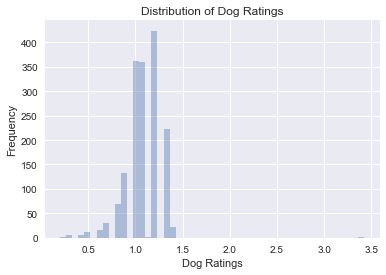

In [60]:
# visualize dog ratings distribution
g11 = sns.distplot(df["rating"], kde=False)
g11.set(xlabel="Dog Ratings", ylabel="Frequency")
plt.title("Distribution of Dog Ratings")

There seem to be outliers on both ends of the dog ratings distribution. Proceed to exclude the top and bottom 1% of dog ratings data.

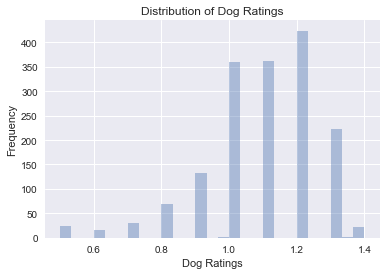

In [61]:
# trim top and bottom 1% of dog ratings
g12 = sns.distplot(df["rating"].clip(df["rating"].quantile(0.01), df["rating"].quantile(0.99), axis=1), kde=False)
g12.set(xlabel="Dog Ratings", ylabel="Frequency")
plt.title("Distribution of Dog Ratings")
plt.savefig('g12.jpg')

Most dogs received a rating ratio of 1.0 to 1.2, with relatively few dogs received a rating ratio below 1.0. In other words, most dogs received a rating of more than 10/10. They must have been some very good dogs.

### Dog Ratings, Retweet Count, and Favorite Count

In [62]:
# compute correlation between dog ratings and retweet count
# excluding top and bottom 1% of dog ratings
df["rating"].clip(df["rating"].quantile(0.01), df["rating"].quantile(0.99), axis=1).corr(df["retweet_count"])

0.33294576860262887

In [63]:
# compute correlation between dog ratings and favorite count
# excluding top and bottom 1% of dog ratings
df["rating"].clip(df["rating"].quantile(0.01), df["rating"].quantile(0.99), axis=1).corr(df["favorite_count"])

0.4428743255045586

There seems to be a positive and modest relationship between dog ratings and retweet count. There seems to also be a positive and modest relationship between dog ratings and favorite count. Note that the top and bottom 1% of dog ratings have been excluded from calculations. The above correlations suggest that tweets that gave dogs higher ratings tend to be retweeted more often, and tend to be favorited more often.

### Dog Ratings Over Time

In [64]:
# set timestamp as datetimeindex
df.index = df["timestamp"]

In [65]:
# compute mean ratings for each month
# excluding top and bottom 1% of dog ratings
df["rating"].clip(df["rating"].quantile(0.01), df["rating"].quantile(0.99), axis=1).resample('M').mean()

timestamp
2015-11-30    0.948444
2015-12-31    1.008219
2016-01-31    1.040580
2016-02-29    1.044086
2016-03-31    1.063810
2016-04-30    1.058000
2016-05-31    1.102083
2016-06-30    1.029412
2016-07-31    1.084615
2016-08-31    1.114894
2016-09-30    1.116263
2016-10-31    1.162917
2016-11-30    1.204545
2016-12-31    1.196154
2017-01-31    1.228814
2017-02-28    1.242373
2017-03-31    1.239535
2017-04-30    1.215152
2017-05-31    1.265714
2017-06-30    1.256098
2017-07-31    1.279348
2017-08-31    1.300000
Freq: M, Name: rating, dtype: float64

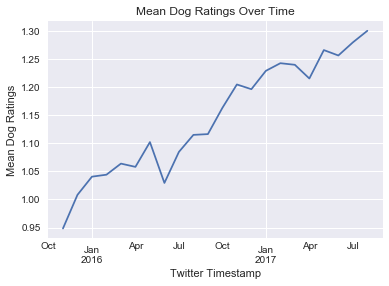

In [66]:
# visualize mean dog ratings for each month
# excluding top and bottom 1% of dog ratings
df["rating"].clip(df["rating"].quantile(0.01), df["rating"].quantile(0.99), axis=1).resample('M').plot()
plt.title("Mean Dog Ratings Over Time")
plt.xlabel("Twitter Timestamp")
plt.ylabel("Mean Dog Ratings")
plt.savefig('g31.jpg')

Over time, the mean dog ratings for each month tends to increase steadily. At the end of 2015, most dogs on average received a rating of around 10/10. By August 2017, most dogs on average received a rating of around 13/10.